In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from data.data_loader import generateGauss
from utils.integral import grid
from Models.classification import Logistics
from Models.classification.Logistics import generate_gaussian_basis
from utils.vis import plot_beta

In [3]:
h = 0.01
x_grid = grid(h, start=-2, end=12)

mu_A = [1, 1.5, 2, 2.5, 6]
sig_A = 0.4 * np.ones_like(mu_A)
mu_B = [4.5, 7.5, 8.5, 8, 8.5]
sig_B = 0.9 * np.ones_like(mu_A)

class1_data = generateGauss(mu_A, sig_A, x_grid)
class2_data = generateGauss(mu_B, sig_B, x_grid)
all_pdfs = np.vstack([class1_data, class2_data])

y = np.array([0]*len(class1_data) + [1]*len(class2_data))
n_A, n_B = len(class1_data), len(class2_data)

In [4]:
# Logistic Regression
print("\n=== Logistic Regression ===")
M = 10
basis_functions = generate_gaussian_basis(x_grid, M)

moments = np.array([
	[np.trapezoid(f * psi, x_grid) for psi in basis_functions]
	for f in all_pdfs
])
X_design = np.hstack([np.ones((moments.shape[0], 1)), moments])

log_model = Logistics.Model(n_iter=1000, l1_penalty=.01, l2_penalty=0.001, verbose=False)
log_model.fit(X_design, y)
decision_values = log_model.predict_proba(X_design)
preds = log_model.predict(X_design)
print(preds)
acc = np.mean(preds == y)
print(f"[LOGISTIC] Accuracy: {acc*100:.2f}%")



=== Logistic Regression ===
[0 0 0 0 0 1 1 1 1 1]
[LOGISTIC] Accuracy: 100.00%


In [5]:
new_pdf = generateGauss([3], [0.9], x_grid).ravel()

moment = np.array([np.trapezoid(new_pdf * psi, x_grid) for psi in basis_functions])
X_new = np.hstack([1.0, moment])
prob = log_model.predict_proba(X_new.reshape(1, -1))[0]
pred = log_model.predict(X_new.reshape(1, -1))[0]
print(f"[LOGISTIC] New sample → Class: {pred}, Probability (class 1): {prob:.4f}")

[LOGISTIC] New sample → Class: 0, Probability (class 1): 0.4274


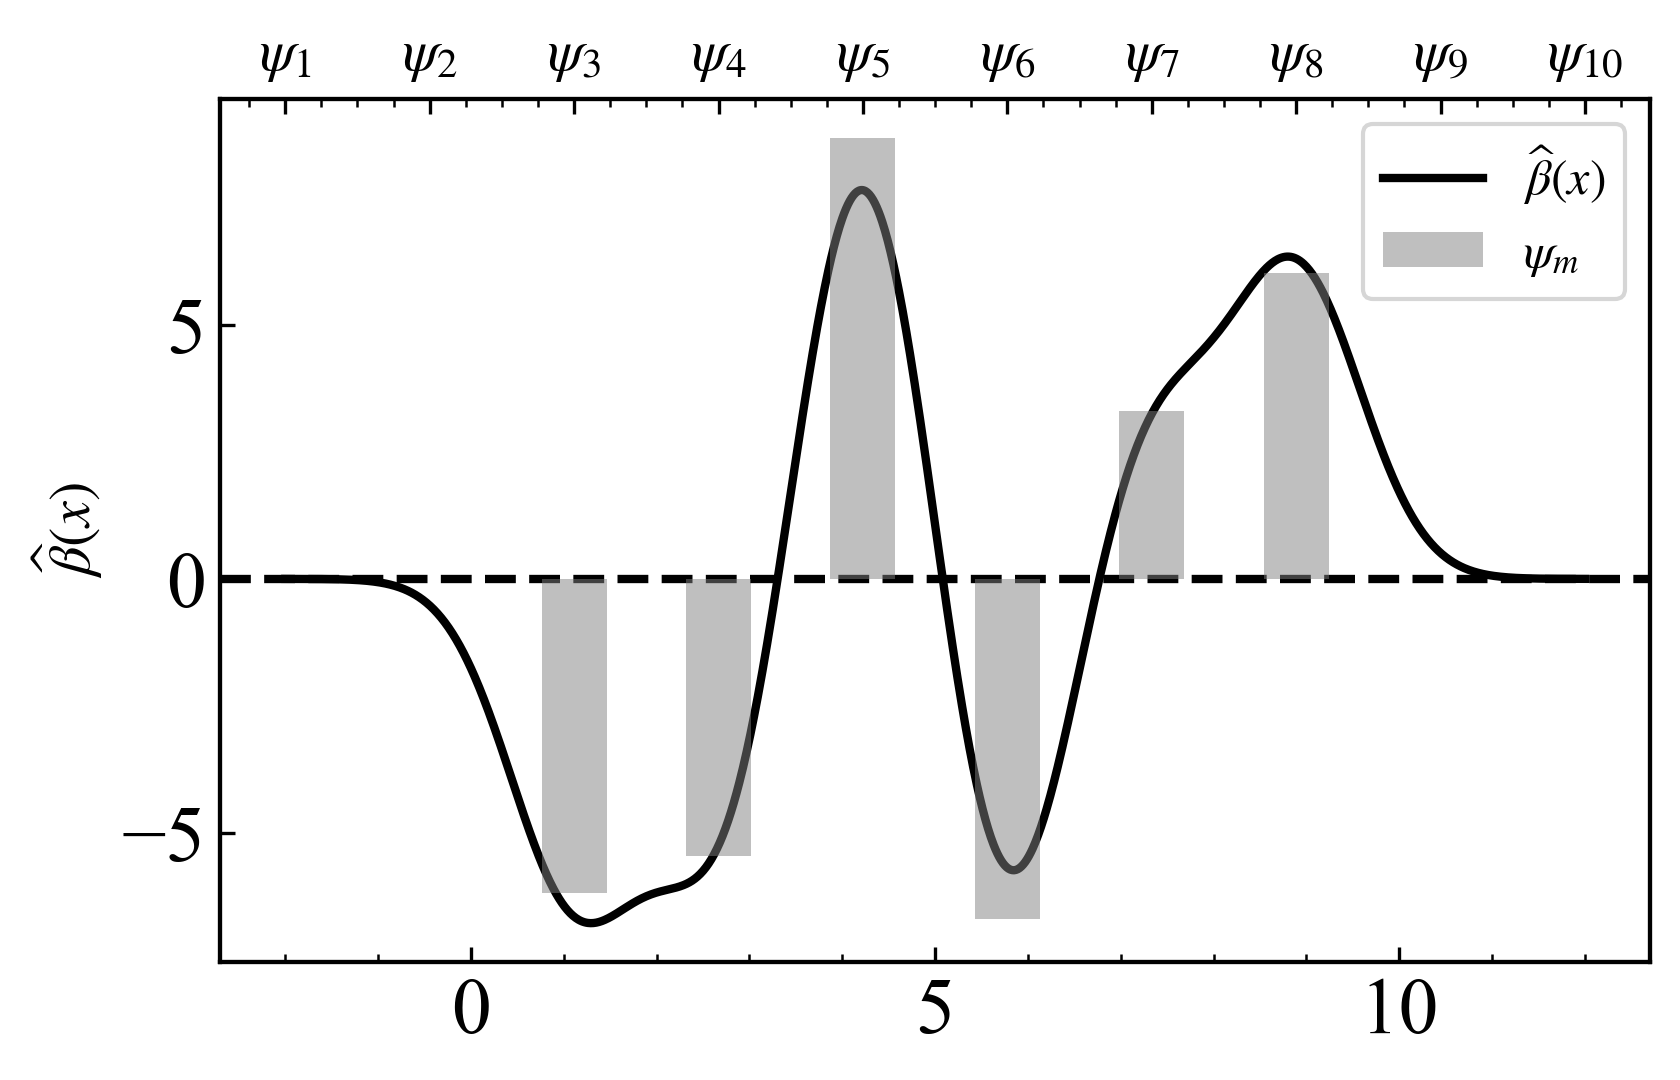

In [6]:
plot_beta(x_grid, log_model, basis_functions)